# **Vehicle Performance Prediction**

## Abstract

Most players in the automotive sector are investing in ML for their marketing efforts, a
much smaller group is putting in place incentives and key performance indicators
(KPIs) to use more ML and automation. Closing the gap requires a stronger commitment
to developing ML capability that is not just useful but also used.

## Problem Statement

Use regression analysis to predict vehicle performance (mileage i.e kilometre travelled
per litre)

## Table of Content

<div class="alert alert-block alert-info">
    <ul>
        <li><a href="#eda">Exploratory Data Analysis</a></li>
        <li><a href="#var-analysis">Variable Analysis</a></li>
        <li><a href="#modelling">Data Modelling</a></li>
        <li><a href="#result">Result</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ul>
</div>

## Import Dependencies and Dataset

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tqdm as tqdm

import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# loading dataset into a dataframe
path = 'https://raw.githubusercontent.com/CosmiX-6/Supervised-Machine-Learning-Solved/master/VehiclePerformancePrediction/Dataset/data.csv'

df = pd.read_csv(path)

display(df.shape)
df.head()

(398, 9)

,origin,cylinders,displacement,horsepower,weight,acceleration,year,name,Kilometer_per_liter
0,1,8,307.0,130,3504,12.0,1970,chevrolet chevelle malibu,7.652587
1,1,8,350.0,165,3693,11.5,1970,buick skylark 320,6.377156
2,1,8,318.0,150,3436,11.0,1970,plymouth satellite,7.652587
3,1,8,304.0,150,3433,12.0,1970,amc rebel sst,6.802299
4,1,8,302.0,140,3449,10.5,1970,ford torino,7.227443


## <div id="eda"></div>&#9724; Exploratory Data Analysis

### Handling Missing Value

<p>In the below cell we have a code which will check if there is any Nan value in entire dataset. If there is any missing data the code will return value $>$ 0.</p>

<p>If value is greater than zero we will look for missing value in individual column.</p>

In [3]:
# code to check missing value in entire dataset
np.sum(df.isna().sum())

0

So, after execution of above cell we know that there is no missing value in the dataset.

Next step is to check the datatype of data that each column contains.

In [4]:
# listing datatype of value the columns contains
df.dtypes

origin                   int64
cylinders                int64
displacement           float64
horsepower              object
weight                   int64
acceleration           float64
year                     int64
name                    object
Kilometer_per_liter    float64
dtype: object

<p>Above code shows us the datatype of column horsepower is object, but horsepower should be a numeric field.</p>

In [5]:
# Finding illegal character that exist in column horsepower
for value in df['horsepower']:
    if value.isnumeric():
        continue
    print(value)

?
?
?
?
?
?


<p>So, we can see that we have few illegal character in horsepower column.</p>

<p>Lets replace the '?' with mean value for respected cylinders.</p>

#### Missing value treatment

In [6]:
# replacing '?' with Nan value
df['horsepower'].replace({'?':np.nan}, inplace=True)

# converting the datatypes of horsepower value from string to int
df['horsepower'] = pd.to_numeric(df['horsepower'])

# filling Nan value with mean horspower value groupped by cylinder space
df['horsepower'] = df.groupby('cylinders')['horsepower'].transform(lambda x:x.fillna(x.mean()))

In [7]:
df.describe()

,origin,cylinders,displacement,horsepower,weight,acceleration,year,Kilometer_per_liter
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,1.572864,5.454774,193.425879,104.132947,2970.424623,15.568090,1976.010050,9.997073
std,0.802055,1.701004,104.269838,38.310886,846.841774,2.757689,3.697627,3.322917
min,1.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,1970.000000,3.826293
25%,1.000000,4.000000,104.250000,76.000000,2223.750000,13.825000,1973.000000,7.440015
50%,1.000000,4.000000,148.500000,92.000000,2803.500000,15.500000,1976.000000,9.778305
75%,2.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,1979.000000,12.329168
max,3.000000,8.000000,455.000000,230.000000,5140.000000,24.800000,1982.000000,19.811697


## <div id="var-analysis"></div>&#9724; Variable Analysis

#### Numerical Variable Analysis

As we know a vehicle is described by its horsepower, So here Horsepower can be our potential feature in predecting kilometers per litre, Also the mileage depends on the weight of the vechile.

So, we can consider Weight and Horsepower as our potential predictors.

Lets start with horsepower,

#### Horsepower vs Kilometer_per_litre

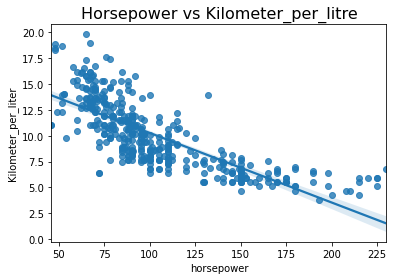

In [8]:
# plotting horsepower with respect to Kilometer per litre
sns.regplot(x='horsepower', y='Kilometer_per_liter', data=df)
plt.title('Horsepower vs Kilometer_per_litre', fontsize=16)
plt.show()

From above graph we can see that the horsepower is negatively correalted with Kilometer_per_liter. Let's check the score of relation.

In [9]:
# finding correlation value
df[['horsepower', 'Kilometer_per_liter']].corr()

,horsepower,Kilometer_per_liter
horsepower,1.000000,-0.775608
Kilometer_per_liter,-0.775608,1.000000


<p>~ -0.776 which means horsepower has strong negative correlation with Kilometer per liter.</p>

#### Weight vs Kilometer_per_litre

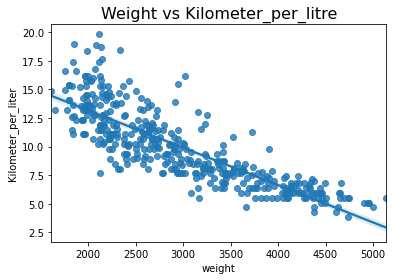

In [10]:
# plotting weight with respect to Kilometer per litre
sns.regplot(x='weight', y='Kilometer_per_liter', data=df)
plt.title('Weight vs Kilometer_per_litre', fontsize=16)
plt.show()

From above graph we can see that the weight is negatively correalted with Kilometer_per_liter. Let's check the score of relation.

In [11]:
# finding correlation value
df[['weight', 'Kilometer_per_liter']].corr()

,weight,Kilometer_per_liter
weight,1.000000,-0.831741
Kilometer_per_liter,-0.831741,1.000000


<p>~ -0.832 which means weight has strong negative correlation with Kilometer per liter.</p>

#### Displacement vs Kilometer_per_litre

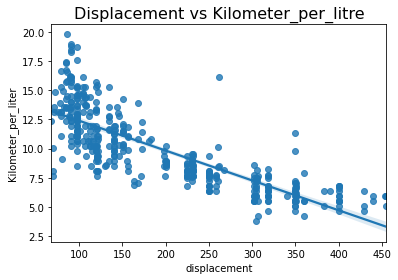

In [12]:
# plotting displacement with respect to Kilometer per litre
sns.regplot(x='displacement', y='Kilometer_per_liter', data=df)
plt.title('Displacement vs Kilometer_per_litre', fontsize=16)
plt.show()

From above graph we can see that the displacement is negatively correalted with Kilometer_per_liter. Let's check the score of relation.

In [13]:
# finding correlation value
df[['displacement', 'Kilometer_per_liter']].corr()

,displacement,Kilometer_per_liter
displacement,1.000000,-0.804203
Kilometer_per_liter,-0.804203,1.000000


<p>-0.804 which means displacement has strong negative correlation with Kilometer per liter.</p>

#### Acceleration vs Kilometer_per_litre

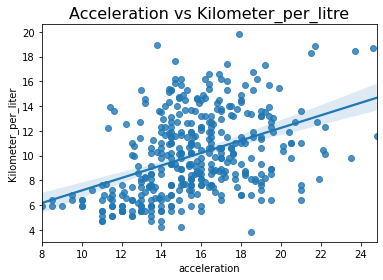

In [14]:
# plotting acceleration with respect to Kilometer per litre
sns.regplot(x='acceleration', y='Kilometer_per_liter', data=df)
plt.title('Acceleration vs Kilometer_per_litre', fontsize=16)

plt.show()

From above graph we can see that the acceleration has positive correlation with Kilometer_per_liter. Let's check the score of relation.

In [15]:
# finding correlation value
df[['acceleration', 'Kilometer_per_liter']].corr()

,acceleration,Kilometer_per_liter
acceleration,1.000000,0.420289
Kilometer_per_liter,0.420289,1.000000


<p>0.420 which means acceleration has some positive correlation with Kilometer per liter but isn't highly correlated.</p>

In numerical variable we have two more feature i.e year and origin.
These looks numerical but acts as categorical. Below code will show the behaviour of these two feature.

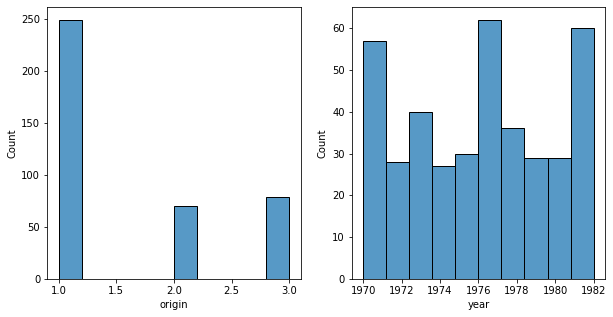

In [16]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
sns.histplot(df['origin'], ax=ax1)

ax2 = plt.subplot(1,2,2)
sns.histplot(df['year'], ax=ax2)

plt.show()

Origin is truly categorical data, so we will dealt with it in categrical analysis. But for now we will look over year feature. The year feature can be converted to numerical by showing that how old the car model is.

i.e We are going to find out the difference in car manufactured year from today.

In [17]:
# below we convert the manufacture year to how old the car is
df['year'] = df['year'].apply(lambda x: 2021 - x)

lets look over the correlation of year vs Kmpl

In [18]:
# finding correlation value
df[['year', 'Kilometer_per_liter']].corr()

,year,Kilometer_per_liter
year,1.000000,-0.579267
Kilometer_per_liter,-0.579267,1.000000


So we can use the year feature as it show some effect to mileage by correlation value of ~ -0.580.

### Categorical Data Analysis

#### Origin weight count

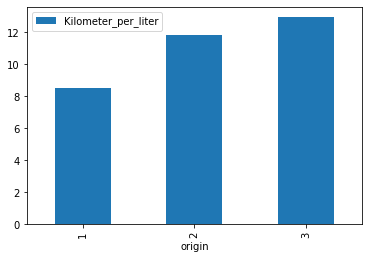

In [19]:
# countplot for origin
group_data = df[['origin', 'Kilometer_per_liter']].groupby('origin').mean()
group_data.plot(kind='bar')
plt.show()

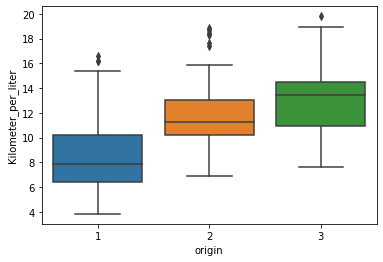

In [20]:
sns.boxplot(df['origin'], df['Kilometer_per_liter'])
plt.show()

We can use origin for vehicle performance predictor

In [21]:
# code to extract brand name from car name
df['name'] = df['name'].apply(lambda name : re.search(r'\w+', name).group())
df['name'].head()

0    chevrolet
1        buick
2     plymouth
3          amc
4         ford
Name: name, dtype: object

In [22]:
# checking for uniquw brand name
df['name'].unique()

array(['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac',
       'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi',
       'saab', 'bmw', 'chevy', 'hi', 'mercury', 'opel', 'fiat',
       'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'toyouta',
       'maxda', 'honda', 'subaru', 'chevroelt', 'capri', 'vw', 'mercedes',
       'cadillac', 'vokswagen', 'triumph', 'nissan'], dtype=object)

Above cell shows some of the brand name repeated beacuse of misspell. So we are going to replace the brand and with actual name.

In [23]:
rename_car = {"toyouta": "toyota", "maxda": "mazda", "vokswagen": "volkswagen", "vw": "volkswagen"}
df['name'].replace(rename_car, inplace = True)
df['name'].unique()

array(['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac',
       'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi',
       'saab', 'bmw', 'chevy', 'hi', 'mercury', 'opel', 'fiat',
       'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'honda',
       'subaru', 'chevroelt', 'capri', 'mercedes', 'cadillac', 'triumph',
       'nissan'], dtype=object)

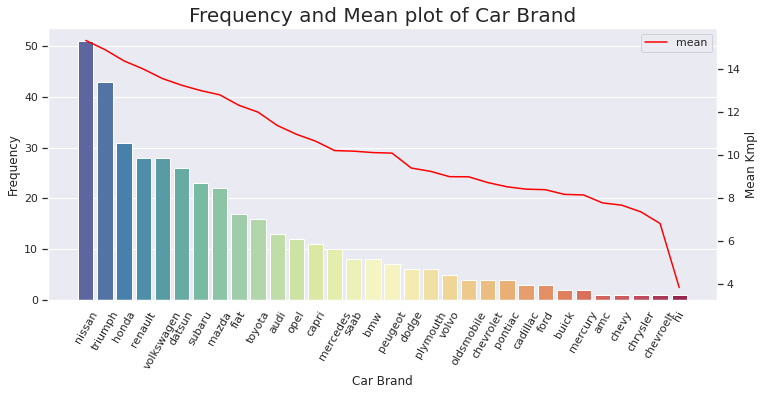

In [24]:
fig = plt.figure(figsize=(12,5))
sns.set()

ax1 = fig.add_subplot(111)

grouped_data_count = df[['name', 'Kilometer_per_liter']].groupby('name',as_index=False).count().sort_values(by="Kilometer_per_liter", ascending=False)
pl = sns.barplot(grouped_data_count['name'], grouped_data_count['Kilometer_per_liter'], palette="Spectral_r", label='frequency')
plt.ylabel('Frequency')
plt.xlabel('Car Brand')

ax2 = ax1.twinx()
grouped_data_mean = df[['name', 'Kilometer_per_liter']].groupby('name',as_index=False).mean().sort_values(by="Kilometer_per_liter", ascending=False)
sns.lineplot(grouped_data_mean['name'], grouped_data_mean['Kilometer_per_liter'], color="red", ax=ax2, label='mean')
ax2.grid(False)
plt.ylabel('Mean Kmpl')

plt.legend()
plt.title("Frequency and Mean plot of Car Brand", fontsize=20)
plt.setp(pl.get_xticklabels(), rotation=60)
plt.show()

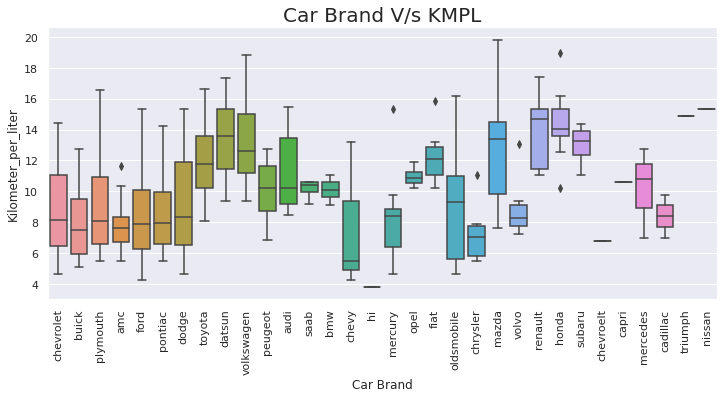

In [25]:
plt.figure(figsize=(12,5))
sns.boxplot(df['name'], df['Kilometer_per_liter'])

plt.title('Car Brand V/s KMPL', fontsize=20)
plt.xlabel('Car Brand')
plt.xticks(rotation=90)
plt.show()

<p>After seeing the barplot the brand name doesn't seems to be a good predictor for predicting the mileage of a car here, because most of median lies in same line.</p>

### Correlation

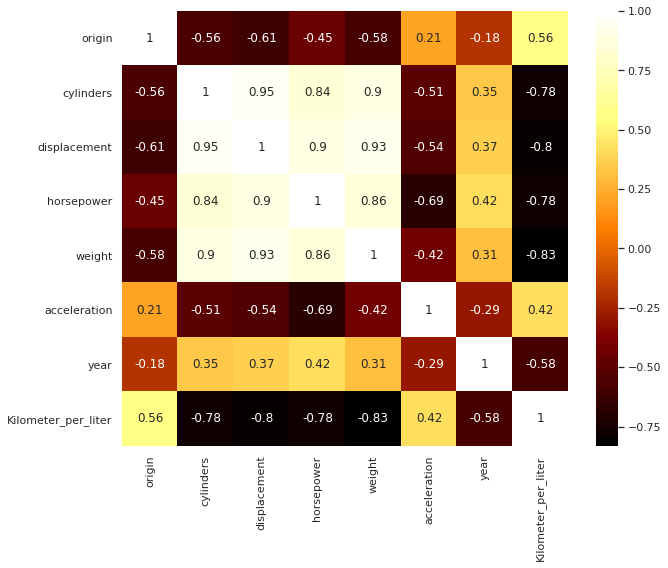

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="afmhot")
plt.show()

#### In above heatmap there can be seen some good correlation for the feature that we have test individually before.

#### Also there is one feature which show the multi-collinearity.

Acceleration is highly colinear to other 4 feature, which are cylinders, dispalcement, horsepower, weight.
So we are going to avoid the use of acceleartion feature for model building.

In [27]:
# dropping column acceleartion
df.drop(['acceleration', 'name'], axis=1, inplace=True)

### We can conclude that:

+ **Numerical Variable**
    + horsepower
    + weight
    + displacement
    + year
    + cylinders


+ **Categorical Variable**
    + origin
    
### are good predictors and can be used for model building.

## Pre processing data for data modelling

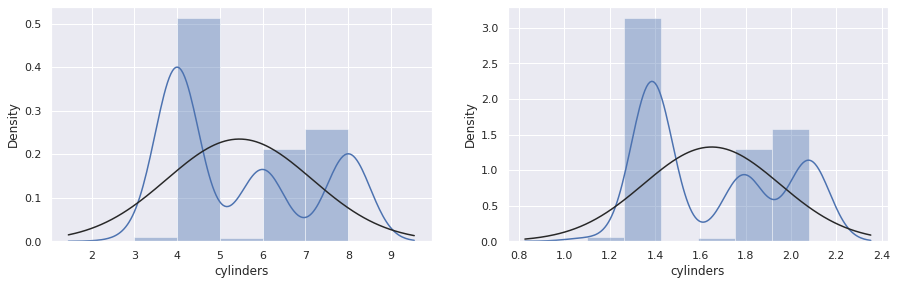

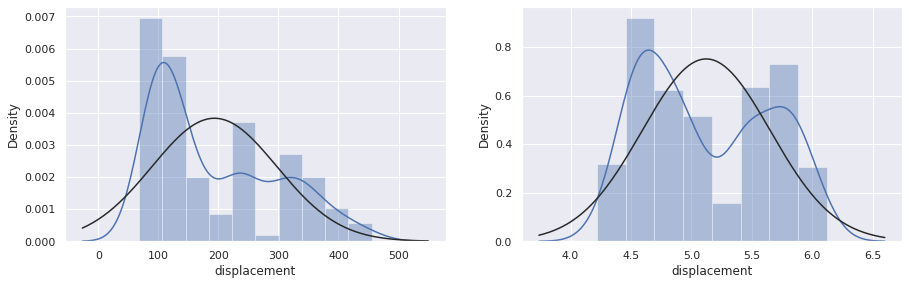

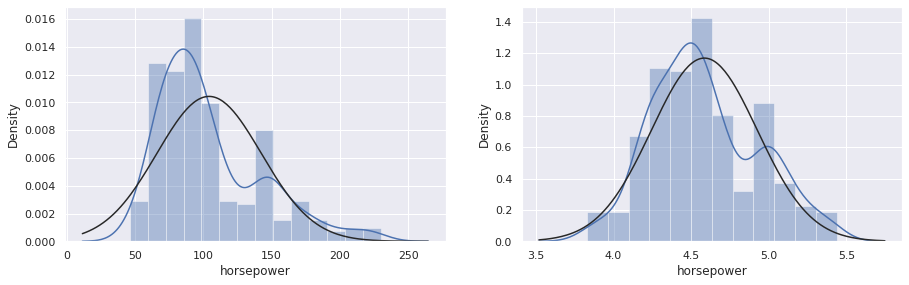

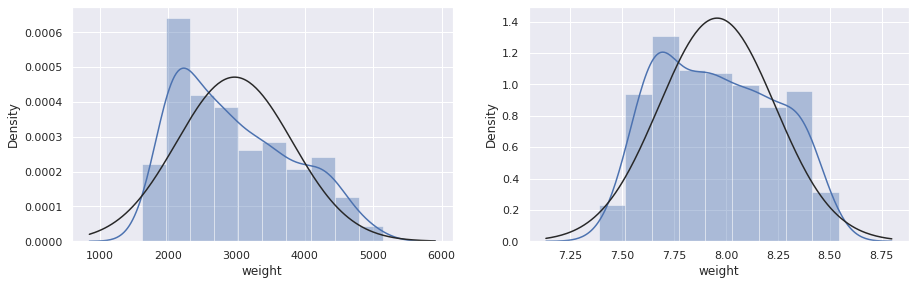

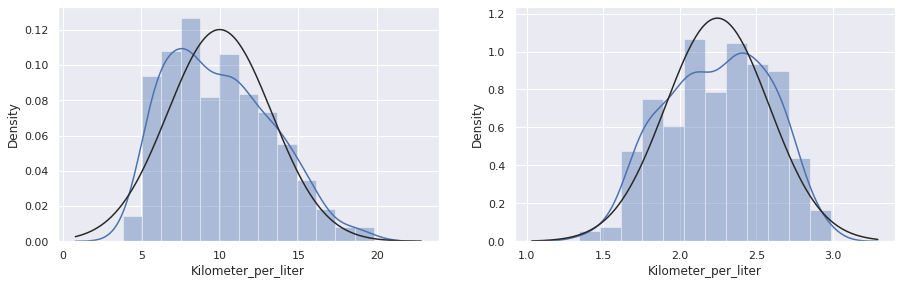

In [28]:
# grabing the name of numerical columns
df_col = list(df.select_dtypes(include=np.number))
df_col.remove('origin')
df_col.remove('year')

# plotting graph using subplot
for count, col in enumerate(df_col):
    plt.figure(figsize = (15, 25))
    count = (count+1)*2
    
    # before normalizing
    sns.distplot(df[col], kde=True, fit=norm, ax=plt.subplot(5,2,count-1))
    
    # using log transformation
    df[col] = np.log(df[col])
    
    # after normalizing
    sns.distplot(df[col], kde=True, fit=norm, ax=plt.subplot(5,2,count))
    
plt.show()

**Coming back to origin column** <br />
Origin is an categorical column which refers to region.
So will create dummies for origin column.

In [29]:
vehicle = pd.concat([df, pd.get_dummies(df['origin'], prefix='origin', drop_first=True)], axis=1)
vehicle.drop('origin', axis=1, inplace=True)

### Save data for modelling

vehicle = df[['cylinders', 'displacement', 'horsepower', 'weight', 'year', 'name', 'Kilometer_per_liter', 'origin_2', 'origin_3']]

In [30]:
# saving the dataframe
vehicle.to_csv('Dataset/vehicle.csv', index=False)

## <div id="modelling"></div>&#9724; Data Modelling

In [31]:
# Loading dataset for modelling
vehicle_df = pd.read_csv("https://raw.githubusercontent.com/CosmiX-6/Supervised-Machine-Learning-Solved/master/VehiclePerformancePrediction/Dataset/vehicle.csv")
vehicle_df.head()

,cylinders,displacement,horsepower,weight,year,Kilometer_per_liter,origin_2,origin_3
0,2.079442,5.726848,4.867534,8.161660,51,2.035044,0,0
1,2.079442,5.857933,5.105945,8.214194,51,1.852722,0,0
2,2.079442,5.762051,5.010635,8.142063,51,2.035044,0,0
3,2.079442,5.717028,5.010635,8.141190,51,1.917261,0,0
4,2.079442,5.710427,4.941642,8.145840,51,1.977885,0,0


In [32]:
summary = smf.ols('Kilometer_per_liter~cylinders+displacement+horsepower+weight+year+origin_2+origin_3', vehicle_df).fit()

In [33]:
summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Kilometer_per_liter   R-squared:                       0.890
Model:                             OLS   Adj. R-squared:                  0.888
Method:                  Least Squares   F-statistic:                     451.6
Date:                 Sun, 22 Aug 2021   Prob (F-statistic):          1.06e-182
Time:                         18:50:25   Log-Likelihood:                 305.09
No. Observations:                  398   AIC:                            -594.2
Df Residuals:                      390   BIC:                            -562.3
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.1491      0.362     28.053      0.000       9.438      10.860
cylinders       -0.0772      0.061     -1.267      0.206      -0.197       0.043
displacement     0.0610      0.057      1.080      0.281      -0.050       0.172
horsepower      -0.1549      0.039     -4.009      0.000      -0.231      -0.079
weight          -0.7557      0.067    -11.207      0.000      -0.888      -0.623
year            -0.0308      0.002    -17.628      0.000      -0.034      -0.027
origin_2         0.0625      0.021      3.046      0.002       0.022       0.103
origin_3         0.0503      0.021      2.452      0.015       0.010       0.091
==============================================================================
Omnibus:                        5.964   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                7.517
Skew:                          -0.127   Prob(JB):                       0.0233
Kurtosis:                       3.623   Cond. No.                     3.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
**Evaluation Function:**

In [34]:
# function to print model report
def model_evaluate(model, train_feature, test_feature, train_target, test_target):
    '''
    Takes 5 positional argument as input and
    Prints the model score for both training, testing data.
    '''
    evaluation = {"train" : {}, "test" : {}}
    for key in evaluation.keys():
        evaluation[key]["predict"] = model.predict(eval(f'{key}_feature'))
        evaluation[key]["rmse"] = mean_squared_error(eval(f'{key}_target'), evaluation[key]["predict"], squared=False)
        evaluation[key]["r2_score"] = r2_score(eval(f'{key}_target'), evaluation[key]["predict"])
        evaluation[key]["mae"] = mean_absolute_error(eval(f'{key}_target'), evaluation[key]["predict"])
    
    for key, value in evaluation.items():
        print(f"{key.title()}ing report")
        print("---------------------------------")
        print(f"RMSE value : {value['rmse']}\nR2 Score : {value['r2_score']}\nMean Absolute Error : {value['mae']}\n")
        
    fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # plotting train set
    sns.distplot(train_target, hist=False, color="r", label="Actual Value", ax=ax_1) # actual data
    sns.distplot(evaluation["train"]["predict"], hist=False, color="b", label="Fitted Values" , ax=ax_1) # predicted data
    ax_1.title.set_text('Train data Report')
    ax_1.legend(loc='best')
    
    # plotting test set
    sns.distplot(test_target, hist=False, color="r", label="Actual Value", ax=ax_2) # actual data
    sns.distplot(evaluation["test"]["predict"], hist=False, color="b", label="Fitted Values" , ax=ax_2) # predicted data
    ax_2.title.set_text('Test data Report')
    ax_2.legend(loc='best')

    fig.suptitle('Actual vs Fitted Values')
    ax_1.set(ylabel ='Count')
    ax_2.set(ylabel ='Count')

    plt.show()
    plt.close()

Initializing variable contaiining predictors and target

In [35]:
X_data = vehicle_df.drop('Kilometer_per_liter', axis=1) # Independent Variable

y_data = vehicle_df.Kilometer_per_liter # Dependent Variable

In [36]:
# splitting data for training and testing model
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=123)

#### **Linear Regression Model**

In [37]:
lrm = LinearRegression()
lrm.fit(x_train, y_train)

LinearRegression()

Training report
---------------------------------
RMSE value : 0.1114609649663023
R2 Score : 0.8936751156548194
Mean Absolute Error : 0.08527130008531773

Testing report
---------------------------------
RMSE value : 0.1176416416234053
R2 Score : 0.8712574866211046
Mean Absolute Error : 0.09178761992879567



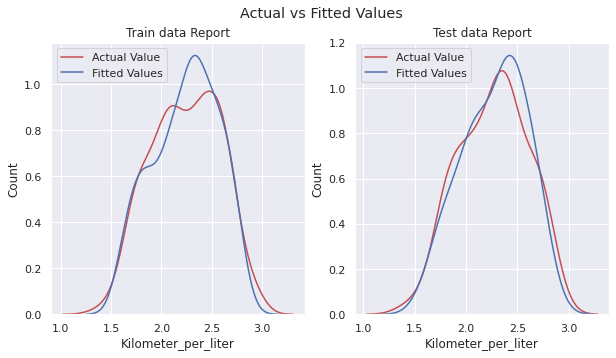

In [38]:
model_evaluate(lrm, x_train, x_test, y_train, y_test)

#### **Stochastic Gradient Descent Regressor**

In [39]:
alphas = np.linspace(0.00001, 1, 500)
eta = np.linspace(0.0001, 0.5, 20)
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
sgd_result = {}

df = pd.DataFrame(data=0, columns=eta, index=alphas)

for count_loss, loss in enumerate(loss):
    for count_row, alpha in enumerate(tqdm.tqdm_notebook(alphas, ascii=True, desc=f"{count_loss+1}/4 SGD Fit")):
        for count_col, lr in enumerate(eta):
            sgd = SGDRegressor(alpha=alpha, eta0=lr, loss=loss)
            sgd.fit(x_train, y_train)
            df.iloc[count_row, count_col] = mean_squared_error(y_test, sgd.predict(x_test), squared=False)
    sgd_result[loss] = df

1/4 SGD Fit:   0%|          | 0/500 [00:00<?, ?it/s]

2/4 SGD Fit:   0%|          | 0/500 [00:00<?, ?it/s]

3/4 SGD Fit:   0%|          | 0/500 [00:00<?, ?it/s]

4/4 SGD Fit:   0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
for key, value in sgd_result.items():
    print(f"{key:30} >> {df.min().head(1)}\n")

squared_loss                   >> 0.0001    0.440675
dtype: float64

huber                          >> 0.0001    0.440675
dtype: float64

epsilon_insensitive            >> 0.0001    0.440675
dtype: float64

squared_epsilon_insensitive    >> 0.0001    0.440675
dtype: float64



Now we know the learning rate = 0.0001 has the minimum rmse. Let's find alpha value at minimum rmse on eta = 0.000100 

In [41]:
# finding minimum alpha value for minimum test rmse
sgd_result['squared_loss'][df[0.000100]==df[0.000100].min()]

,0.000100,0.026411,0.052721,0.079032,0.105342,0.131653,0.157963,0.184274,0.210584,0.236895,0.263205,0.289516,0.315826,0.342137,0.368447,0.394758,0.421068,0.447379,0.473689,0.500000
0.380768,0.440675,2.401045e+12,5.005936e+12,1.154970e+13,4.445980e+12,1.845761e+13,2.979170e+13,1.326943e+13,2.319483e+13,3.249673e+13,2.464956e+13,1.914084e+13,4.190642e+13,5.974509e+13,1.102860e+13,1.338893e+13,4.713527e+13,4.559050e+13,4.603461e+13,4.834005e+13


In [42]:
sgd = SGDRegressor(alpha=0.571147, eta0=0.0001)
sgd.fit(x_train, y_train)

SGDRegressor(alpha=0.571147, eta0=0.0001)

Training report
---------------------------------
RMSE value : 0.47328378586384384
R2 Score : -0.9170461782194099
Mean Absolute Error : 0.39195201057584805

Testing report
---------------------------------
RMSE value : 0.45934389153226485
R2 Score : -0.9627985196487725
Mean Absolute Error : 0.36762162397248177



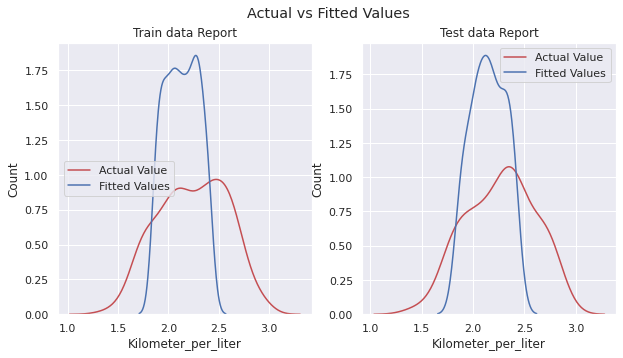

In [43]:
model_evaluate(sgd, x_train, x_test, y_train, y_test)

## <div id="result"></div>&#9724; Result

### Model Score :

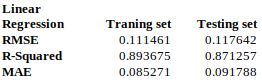

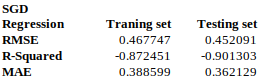

## <div id="conclusion"></div>&#9724; Conclusion

<p>Comparing these two models, we conclude that the Linear Regression showed the best fit for the vehicle performance prediction problem. Also the result makes sense as we have only few data with more potential predicting features.</p>

<div style="margin-top:100px; float:right; text-align:right;">
        <h3>Author</h3>
        <h4>Akash Sharma</h4>
        <a href="https://www.linkedin.com/in/akash-sharma-01775b14a">
            <img src="https://img.shields.io/static/v1?logo=linkedin&labelColor=orange&logoColor=white&label=&message=LinkedIn&color=informational&style=plastic" alt="LinkedIn">
        </a>
        <a href="https://discord.com/users/366283102462541865">
            <img src="https://img.shields.io/static/v1?logo=discord&labelColor=grey&logoColor=white&label=&message=Discord&color=blue&style=plastic" alt="Discord">
        </a>
        <a href="https://github.com/CosmiX-6">
            <img src="https://img.shields.io/static/v1?logo=github&labelColor=green&logoColor=black&label=&message=GitHub&color=black&style=plastic" alt="GitHub">
        </a>
</div>